In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from regex import D

from sklearn.linear_model import LinearRegression
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error as mse



import warnings
warnings.filterwarnings("ignore")

In [2]:

def merge_data(df, large= True):

    """
        df_run : new data that has Kv , ms
        df_c : old data that has NewCFactor and N_pulses
    """

    df_run = df[df.apply(lambda row: row.astype(str).str.contains('Last run kV').any(), axis=1)]
    if large:
        df_c = df[df.apply(lambda row: row.astype(str).str.contains(f'\[Focus=Largest\]').any(), axis=1)]
    else:
        df_c = df[df.apply(lambda row: row.astype(str).str.contains(f'\[Focus=Smallest\]').any(), axis=1)]

    df_run["TimeStamp"] = pd.to_datetime(df_run["TimeStamp"])
    df_c["TimeStamp"] = pd.to_datetime(df_c["TimeStamp"])

    df_run = df_run.sort_values(by="TimeStamp")
    # df_run["tt"] = df_run["TimeStamp"]
    df_c = df_c.sort_values(by="TimeStamp")

    merged_df = pd.merge_asof(df_c , df_run , on='TimeStamp' , direction='nearest')
    return merged_df


In [3]:

# merged_df['RunLength'] = merged_df["MemoField"].str.extract(r'RunLength=[^\d]*(\d+(?:\.\d+)?)');
def extract_data(df):
    df = df.copy()
    df["N_Pulses"] =  df["MemoField_x"].str.extract(r'NumberOfPulses=[^\d]*(\d+(?:\.\d+)?)');
    df["NewCFactor"] = df["MemoField_x"].str.extract(r'NewCFactor=[^\d]*(\d+(?:\.\d+)?)');
    df["kV"] = df["Description_y"].str.extract(r'kV = [^\d]*(\d+(?:\.\d+)?)');
    df["mA"] = df["Description_y"].str.extract(r'mA = [^\d]*(\d+(?:\.\d+)?)');
    df["ms"] = df["Description_y"].str.extract(r'ms = [^\d]*(\d+(?:\.\d+)?)');
    df = df[["TimeStamp" ,"NewCFactor" , "N_Pulses" , "kV"  , "mA" , "ms"]]   
    return df



In [4]:

def get_cum(df):
    df["KW.S"] = (df["N_Pulses"].astype(float) * df["kV"].astype(float) * df["mA"].astype(float) * df["ms"].astype(float)) / 1e6
    #resort
    df = df.sort_values(by="TimeStamp")
    df["KW.S_Cum"] = np.cumsum(df["KW.S"])
    return df



def plot(df , large = True):
    x= df["NewCFactor"]
    y = df["KW.S_Cum"]
    plt.plot(x, y )

    # Invert the plot
    plt.gca().invert_xaxis()


    plt.xlabel('NewCFactor')
    plt.ylabel("Cumulative KW.S")
    plt.title(f"{'Largest' if large else 'Smallest'} Data")
    plt.show()



In [5]:

def train_model(df , large =True):
    X= df["NewCFactor"]
    y = df["KW.S_Cum"]


    X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = .2 , random_state=3407)


    lr = LinearRegression()

    lr.fit(X_train.array.reshape(-1,1) , y_train)

    # print(f"rmse :  {mse(y_test , lr.predict(X_test.array.reshape(-1,1)) , squared = False)}")

    return lr



In [6]:

def get_data(df):
    df_merged = merge_data(df)

    df_merged_small =  merge_data(df, large=False)

    return df_merged  , df_merged_small
## CHANGED
def preprocess_plot_model(df):
       
    df_data = extract_data(df)
    df_data_cum  = get_cum(df_data)

    plot(df_data_cum)

    model = train_model(df_data_cum)

    return df_data_cum , model



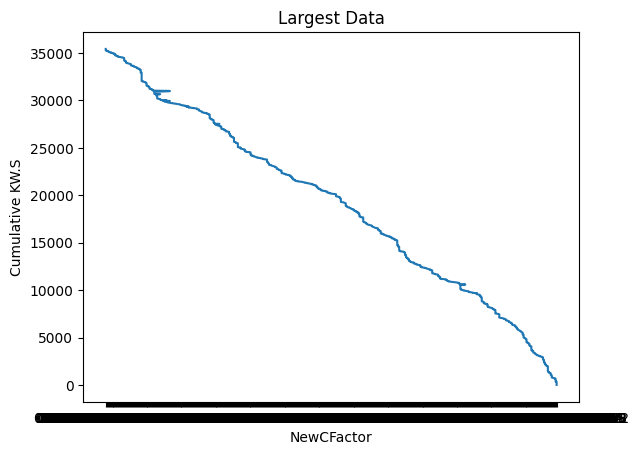

KW.S_Cum at Fail Point for largest data '0.9453574604'  =  [1733949.4474222]
remaining_KWs at Fail Point for largest data '0.9453574604'  =  1698533.09562471


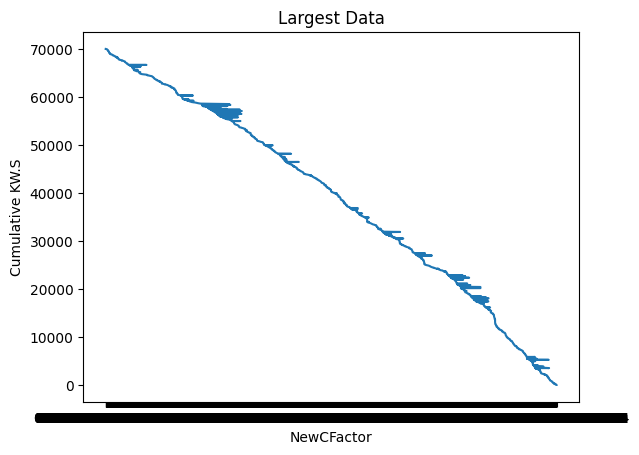

KW.S_Cum at Fail Point for smallest data '0.9453574604'  =  [1484416.88828211]
remaining_KWs at Fail Point for smallest data '0.9453574604'  =  1414307.293959853


In [7]:

# def main(data_path):
fail_point = 0.9453574604
data_path= "../data/MCC from 4-4-2023 to 7-5-2023.XML"

df = pd.read_xml(data_path).sort_values(by="TimeStamp")

df_large , df_small = get_data(df)

## for large
df_large_final , model_large = preprocess_plot_model(df_large)
KWs_pred = model_large.predict(np.array([fail_point]).reshape(1,-1)  )
remaining_KWs = KWs_pred[0] - df_large_final.tail(1)["KW.S_Cum"].values[0]
print(f"KW.S_Cum at Fail Point for largest data '{fail_point}'  =  {KWs_pred}")
print(f"remaining_KWs at Fail Point for largest data '{fail_point}'  =  {remaining_KWs}")

## for small
df_small_final ,model_small = preprocess_plot_model(df_small)
KWs_pred = model_small.predict(np.array([fail_point]).reshape(1,-1)  )
remaining_KWs = KWs_pred[0] - df_small_final.tail(1)["KW.S_Cum"].values[0]
print(f"KW.S_Cum at Fail Point for smallest data '{fail_point}'  =  {KWs_pred}")
print(f"remaining_KWs at Fail Point for smallest data '{fail_point}'  =  {remaining_KWs}")



## define data path here
## run model
# main(data_path)

In [9]:
df_large_final.head()

,TimeStamp,NewCFactor,N_Pulses,kV,mA,ms,KW.S,KW.S_Cum
0,2023-04-04 13:43:17,0.993906497955322,71,86.8,608.0,7.5,28.102368,28.102368
1,2023-04-04 13:43:37,0.993906497955322,49,68.3,521.5,4.8,8.377459,36.479827
2,2023-04-04 13:44:40,0.993906497955322,36,74.5,690.4,6.1,11.295082,47.774910
3,2023-04-04 13:45:01,0.993906497955322,57,88.4,605.9,7.5,22.897567,70.672476
4,2023-04-04 13:45:34,0.993906497955322,44,120.3,433.8,9.9,22.732283,93.404759


<Axes: xlabel='NewCFactor', ylabel='KW.S_Cum'>

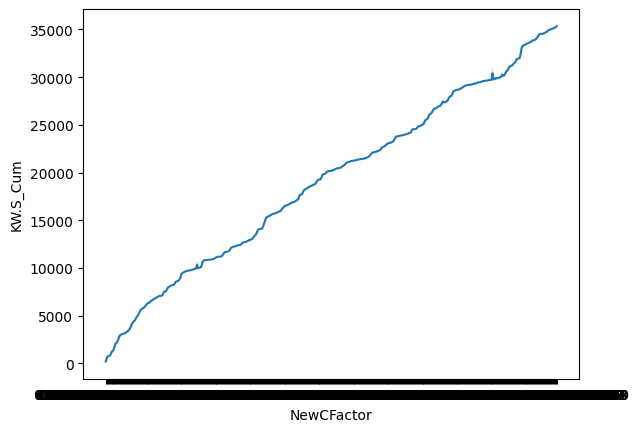

In [20]:
import seaborn as sns
sns.lineplot(data = df_large_final , x ='NewCFactor' , y = "KW.S_Cum" )


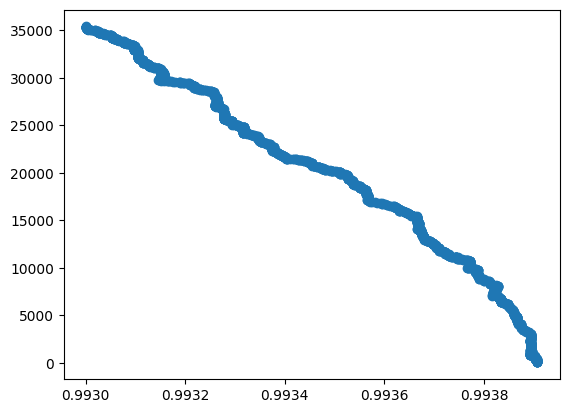

In [69]:
import matplotlib.pyplot as plt
pd.set_option('display.precision', 15)

# plt.figure(figsize=(12 , 12) , )
k=-1
plt.scatter(df_large_final.NewCFactor.astype(np.float128) , df_large_final["KW.S_Cum"])
# plt.xticks([0,1])
# plt.xlim(0 , 10)

In [66]:
df_large_final.NewCFactor.ravel()[:10].astype(np.float128)

array([0.9939065, 0.9939065, 0.9939065, 0.9939065, 0.9939065, 0.9939065,
       0.9939065, 0.9939065, 0.9939065, 0.9939065], dtype=float128)

In [53]:
np.round(adf_large_final.NewCFactor.ravel()[:k] , 2)

TypeError: can't multiply sequence by non-int of type 'float'